## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

In [128]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import numpy as np
plt.style.use('dark_background')

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [129]:
# (re-)load layers
%run modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

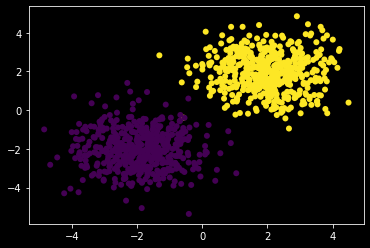

In [130]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [131]:
# net = Sequential()
# net.add(Linear(2, 2))
# net.add(LogSoftMax())

criterion = ClassNLLCriterion()

# print(net)

# Test something like that then 

net = Sequential()
net.add(Linear(2, 4))
net.add(ReLU())
net.add(Linear(4, 2))
net.add(LogSoftMax())

print(net)

Linear 2 -> 4
ReLU
Linear 4 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [132]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 1000

In [133]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

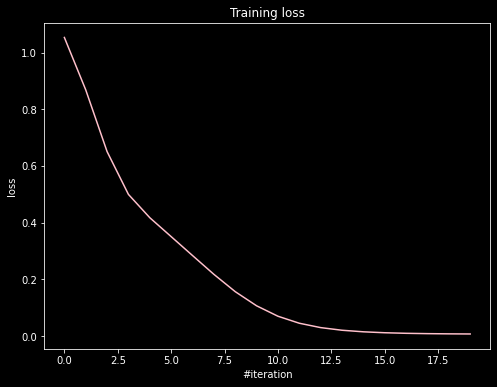

Current loss: 0.006943


In [134]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'pink')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [135]:
# !pip install mnist

In [136]:
#import mnist
#X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

In [137]:
# from sklearn.datasets import fetch_openml
# mnist = fetch_openml('mnist_784')
# x = mnist.data
# y = mnist.target

In [138]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [139]:
from sklearn.model_selection import train_test_split

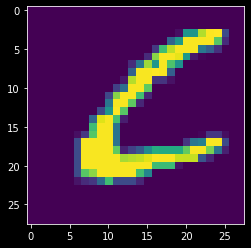

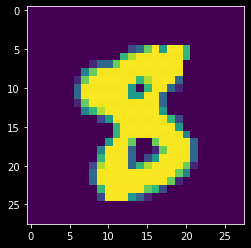

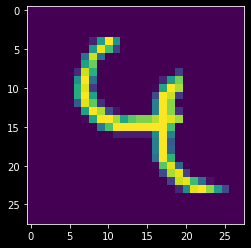

In [140]:
def read_header_im(file_name):
    f = open(file_name, 'rb')
    dims = np.fromfile(file = f, dtype = np.uint32).byteswap(inplace = True)
    number_of_images = dims[1]
    rows = dims[2]
    columns = dims[3]
    
    return number_of_images, rows, columns

def read_header_label(file_name):
    f = open(file_name, 'rb')
    labels = np.fromfile(file = f, dtype = np.uint32).byteswap(inplace = True)
    number_of_labels = labels[1]
    
    return number_of_labels

def open_MNIST():
    #train images
    train_number_of_images , train_rows, train_columns = read_header_im('train-images.idx3-ubyte')
    
    f_train_im = open('train-images.idx3-ubyte', 'rb')
    train_data = np.fromfile(file = f_train_im, dtype = np.uint8).byteswap(inplace = True)
    X_train = train_data[16:].reshape((train_number_of_images , train_rows, train_columns))

    #test_images
    test_number_of_images, test_rows, test_columns = read_header_im('t10k-images.idx3-ubyte')
    
    f_test_im = open('t10k-images.idx3-ubyte', 'rb')
    test_data = np.fromfile(file = f_test_im, dtype = np.uint8).byteswap(inplace = True)
    X_test = test_data[16:].reshape((test_number_of_images, test_rows, test_columns))
    
    #train_labels
    train_number_of_labels = read_header_label('train-labels.idx1-ubyte')
    
    f_train_l = open('train-labels.idx1-ubyte', 'rb')
    train_labels = np.fromfile(file = f_train_l, dtype = np.uint8).byteswap(inplace = True)
    y_train = train_labels[8:].reshape(train_number_of_labels)
    
    #test_labels
    test_number_of_labels = read_header_label('t10k-labels.idx1-ubyte')
    
    f_test_l = open('t10k-labels.idx1-ubyte', 'rb')
    test_labels = np.fromfile(file = f_test_l, dtype = np.uint8)
    y_test = test_labels[8:].reshape( test_number_of_labels)
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = open_MNIST()
X_test = X_test / 255
X_train = X_train / 255

# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

import random
import matplotlib.pyplot as plt

def show_3(x, y):
    for j in range(3):
        i = random.randint(0, 5999)
        plt.imshow(x[i])
        plt.show()
        
show_3(X_test, y_test)

In [141]:
X_test = X_test.reshape((10000, -1))
X_train = X_train.reshape((60000, -1))

One-hot encode the labels first.

In [142]:
# Your code goes here. ################################################
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(handle_unknown='ignore')
y_train = encoder.fit_transform(y_train.reshape(-1, 1)).toarray()
y_test = encoder.fit_transform(y_test.reshape(-1, 1)).toarray()
# y_val = encoder.fit_transform(y_val.reshape(-1, 1)).toarray()

In [143]:
y_train.shape

(60000, 10)

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

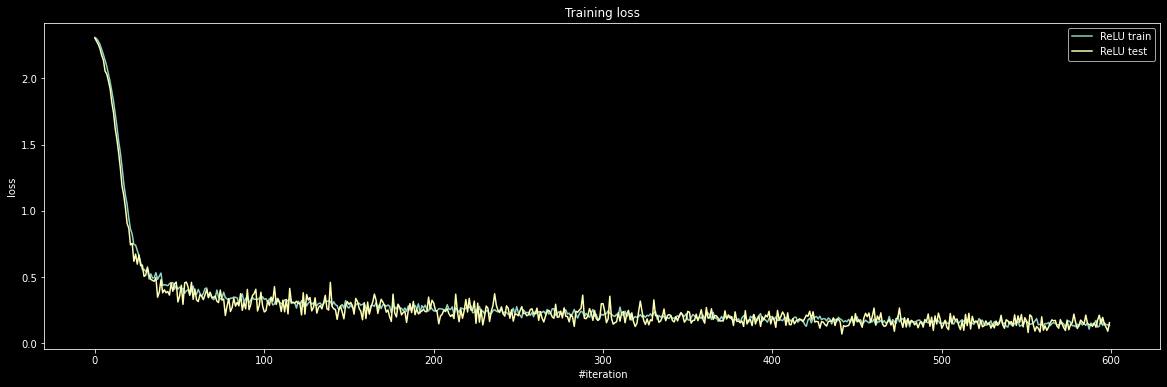

Current train loss: 0.1334851671442294
Current test loss: 0.15414538202085107


In [144]:
#ReLU
# Optimizer params
optimizer_config_ReLU = {'learning_rate' : 5e-2, 'momentum': 0.9}
optimizer_state_ReLU = {}

net_ReLU = Sequential()
net_ReLU.add(Linear(784, 256))
net_ReLU.add(ReLU())
net_ReLU.add(Linear(256, 10))
net_ReLU.add(LogSoftMax())

criterion_ReLU = ClassNLLCriterion()

n_epoch = 15
batch_size = 1500
batch_size_test = 250

loss_history_ReLU = []
loss_history_ReLU_test = []

for i in range(n_epoch):
    print(f'Epoch = {i+1}')
    for (x_batch, y_batch), (x_batch_test, y_batch_test) in zip(get_batches((X_train, y_train), batch_size), get_batches((X_test, y_test), batch_size_test)):
        net_ReLU.zeroGradParameters()
        
        # Forward
        predictions_ReLU = net_ReLU.forward(x_batch)
        loss_ReLU = criterion_ReLU.forward(predictions_ReLU, y_batch)
        
        # Backward
        dp_ReLU = criterion_ReLU.backward(predictions_ReLU, y_batch)
        net_ReLU.backward(x_batch, dp_ReLU)
        
        # Update weights
        sgd_momentum(net_ReLU.getParameters(), net_ReLU.getGradParameters(), optimizer_config_ReLU, optimizer_state_ReLU)
        
        loss_history_ReLU.append(loss_ReLU)
      
    #for x_batch, y_batch in get_batches((X_test, y_test), batch_size_test):
        pred_ReLU_test = net_ReLU.forward(x_batch_test)
        loss_ReLU_test = criterion_ReLU.forward(pred_ReLU_test, y_batch_test)
        loss_history_ReLU_test.append(loss_ReLU_test)
        
    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(20, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history_ReLU, label='ReLU train')
    plt.plot(loss_history_ReLU_test, label='ReLU test')
    plt.legend()
    plt.show()

    print(f'Current train loss: {loss_ReLU}')
    print(f'Current test loss: {loss_ReLU_test}')

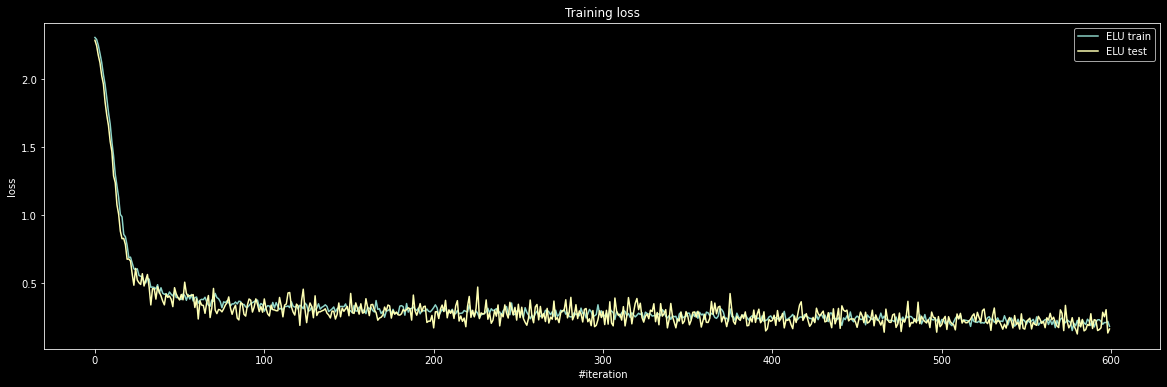

Current train loss: 0.18203937900601014
Current test loss: 0.1620877099999268


In [145]:
#ELU
optimizer_config_ELU = {'learning_rate' : 5e-2, 'momentum': 0.9}
optimizer_state_ELU = {}

net_ELU = Sequential()
net_ELU.add(Linear(784, 256))
net_ELU.add(ELU())
net_ELU.add(Linear(256, 10))
net_ELU.add(LogSoftMax())

criterion_ELU = ClassNLLCriterion()

n_epoch = 15
batch_size = 1500
batch_size_test = 250

loss_history_ELU = []
loss_history_ELU_test = []

for i in range(n_epoch):
    print(f'Epoch = {i}')
    for (x_batch, y_batch), (x_batch_test, y_batch_test) in zip(get_batches((X_train, y_train), batch_size), get_batches((X_test, y_test), batch_size_test)):
        net_ELU.zeroGradParameters()
        
        predictions_ELU = net_ELU.forward(x_batch)
        loss_ELU = criterion_ELU.forward(predictions_ELU, y_batch)
        
        dp_ELU = criterion_ELU.backward(predictions_ELU, y_batch)
        net_ELU.backward(x_batch, dp_ELU)
        
        sgd_momentum(net_ELU.getParameters(), net_ELU.getGradParameters(), optimizer_config_ELU, optimizer_state_ELU)
        
        loss_history_ELU.append(loss_ELU)

        pred_ELU_test = net_ELU.forward(x_batch_test)
        loss_ELU_test = criterion_ELU.forward(pred_ELU_test, y_batch_test)
        loss_history_ELU_test.append(loss_ELU_test)
        
     # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(20, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history_ELU, label='ELU train')
    plt.plot(loss_history_ELU_test, label='ELU test')
    plt.legend()
    plt.show()

    print(f'Current train loss: {loss_ELU}')
    print(f'Current test loss: {loss_ELU_test}')

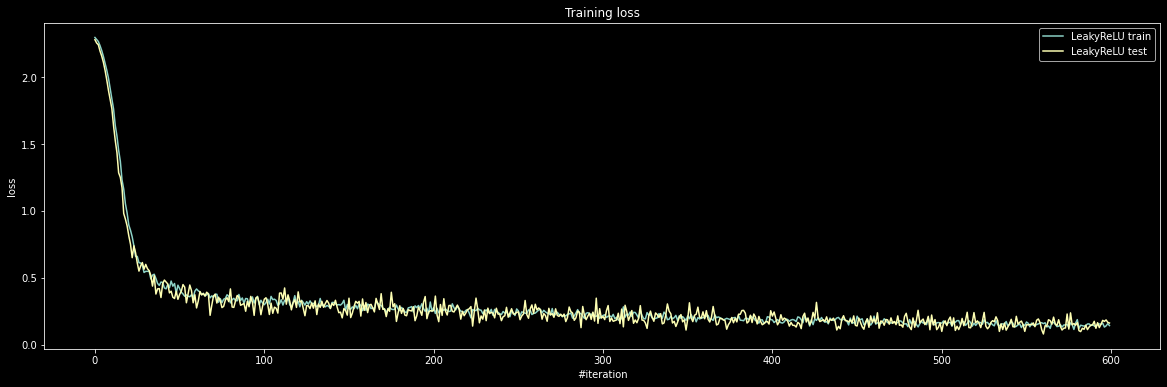

Current train loss: 0.14341612755474892
Current test loss: 0.16245171162515032


In [146]:
#LeakyReLU
optimizer_config_LeakyReLU = {'learning_rate' : 5e-2, 'momentum': 0.9}
optimizer_state_LeakyReLU = {}

net_LeakyReLU = Sequential()
net_LeakyReLU.add(Linear(784, 256))
net_LeakyReLU.add(LeakyReLU())
net_LeakyReLU.add(Linear(256, 10))
net_LeakyReLU.add(LogSoftMax())

criterion_LeakyReLU = ClassNLLCriterion()

n_epoch = 15
batch_size = 1500
batch_size_test = 250

loss_history_LeakyReLU = []
loss_history_LeakyReLU_test = []

for i in range(n_epoch):
    print(f'Epoch = {i}')
    for (x_batch, y_batch), (x_batch_test, y_batch_test) in zip(get_batches((X_train, y_train), batch_size), get_batches((X_test, y_test), batch_size_test)):
        net_LeakyReLU.zeroGradParameters()
        
        predictions_LeakyReLU = net_LeakyReLU.forward(x_batch)
        loss_LeakyReLU = criterion_LeakyReLU.forward(predictions_LeakyReLU, y_batch)
        
        dp_LeakyReLU = criterion_LeakyReLU.backward(predictions_LeakyReLU, y_batch)
        net_LeakyReLU.backward(x_batch, dp_LeakyReLU)
        
        sgd_momentum(net_LeakyReLU.getParameters(), net_LeakyReLU.getGradParameters(), optimizer_config_LeakyReLU, optimizer_state_LeakyReLU)
        
        loss_history_LeakyReLU.append(loss_LeakyReLU)
        
        pred_LeakyReLU_test = net_LeakyReLU.forward(x_batch_test)
        loss_LeakyReLU_test = criterion_LeakyReLU.forward(pred_LeakyReLU_test, y_batch_test)
        loss_history_LeakyReLU_test.append(loss_LeakyReLU_test)

     # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(20, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history_LeakyReLU, label='LeakyReLU train')
    plt.plot(loss_history_LeakyReLU_test, label='LeakyReLU test')
    plt.legend()
    plt.show()

    print(f'Current train loss: {loss_LeakyReLU}')
    print(f'Current test loss: {loss_LeakyReLU_test}')
    

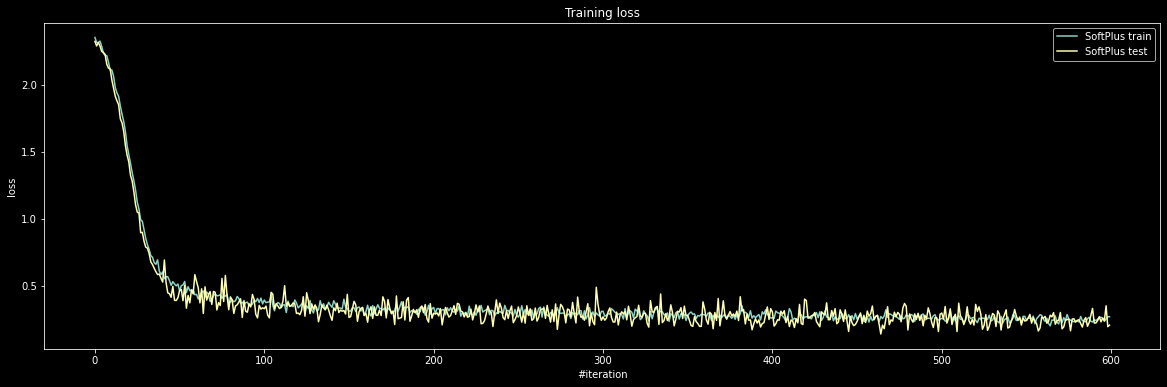

Current train loss: 0.26766749215741875
Current test loss: 0.20450965018743436


In [147]:
#SoftPlus 
optimizer_config_SoftPlus = {'learning_rate' : 5e-2, 'momentum': 0.9}
optimizer_state_SoftPlus = {}

net_SoftPlus = Sequential()
net_SoftPlus.add(Linear(784, 256))
net_SoftPlus.add(SoftPlus())
net_SoftPlus.add(Linear(256, 10))
net_SoftPlus.add(LogSoftMax())

criterion_SoftPlus = ClassNLLCriterion()


n_epoch = 15
batch_size = 1500
batch_size_test = 250

loss_history_SoftPlus = []
loss_history_SoftPlus_test = []

for i in range(n_epoch):
    print(f'Epoch = {i}')
    for (x_batch, y_batch), (x_batch_test, y_batch_test) in zip(get_batches((X_train, y_train), batch_size), get_batches((X_test, y_test), batch_size_test)):
        net_SoftPlus.zeroGradParameters()

        # Forward
        predictions_SoftPlus = net_SoftPlus.forward(x_batch)
        loss_SoftPlus = criterion_SoftPlus.forward(predictions_SoftPlus, y_batch)

        # Backward
        dp_SoftPlus = criterion_SoftPlus.backward(predictions_SoftPlus, y_batch)
        net_SoftPlus.backward(x_batch, dp_SoftPlus)

        # Update weights
        sgd_momentum(net_SoftPlus.getParameters(), net_SoftPlus.getGradParameters(), optimizer_config_SoftPlus, optimizer_state_SoftPlus)
        
        loss_history_SoftPlus.append(loss_SoftPlus)

        pred_SoftPlus_test = net_SoftPlus.forward(x_batch_test)
        loss_SoftPlus_test = criterion_SoftPlus.forward(pred_SoftPlus_test, y_batch_test)
        loss_history_SoftPlus_test.append(loss_SoftPlus_test)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(20, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history_SoftPlus, label='SoftPlus train')
    plt.plot(loss_history_SoftPlus_test, label='SoftPlus test')
    plt.legend()
    plt.show()

    print(f'Current train loss: {loss_SoftPlus}')
    print(f'Current test loss: {loss_SoftPlus_test}')

Посроим все графики loss вместе



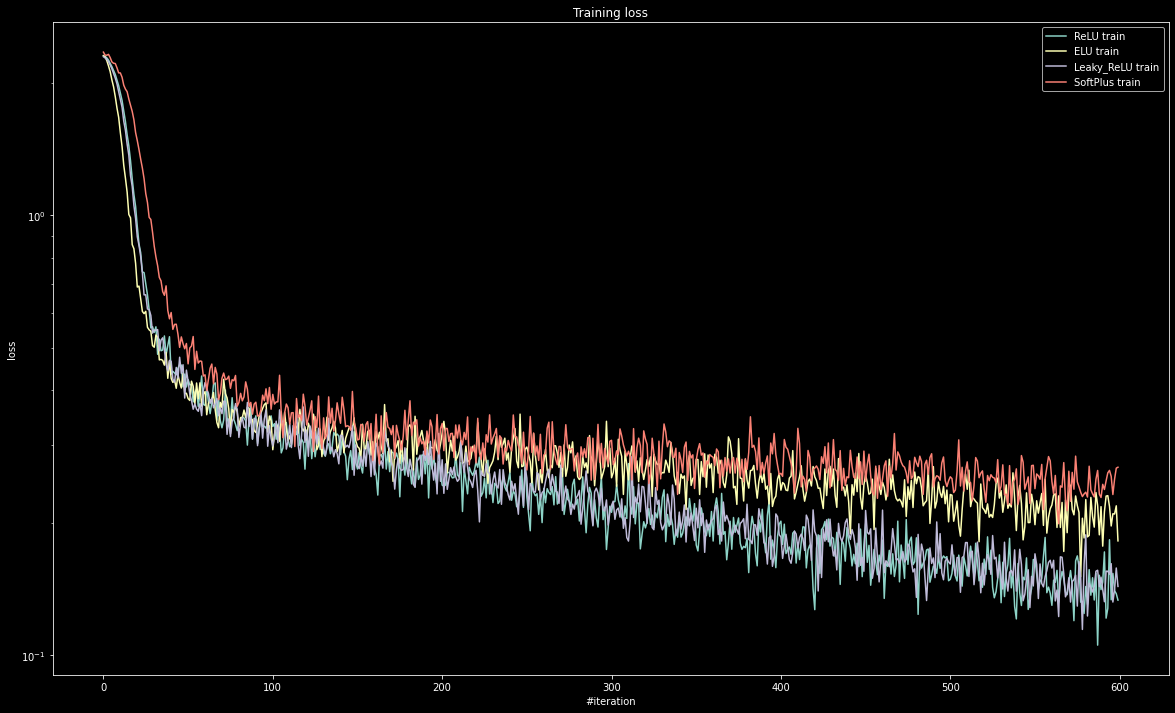

In [148]:
plt.figure(figsize=(20, 12))
plt.title("Training loss")
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.semilogy(loss_history_ReLU, label='ReLU train')
plt.semilogy(loss_history_ELU, label='ELU train')
plt.semilogy(loss_history_LeakyReLU, label='Leaky_ReLU train')
plt.semilogy(loss_history_SoftPlus, label='SoftPlus train')
plt.legend()
plt.show()

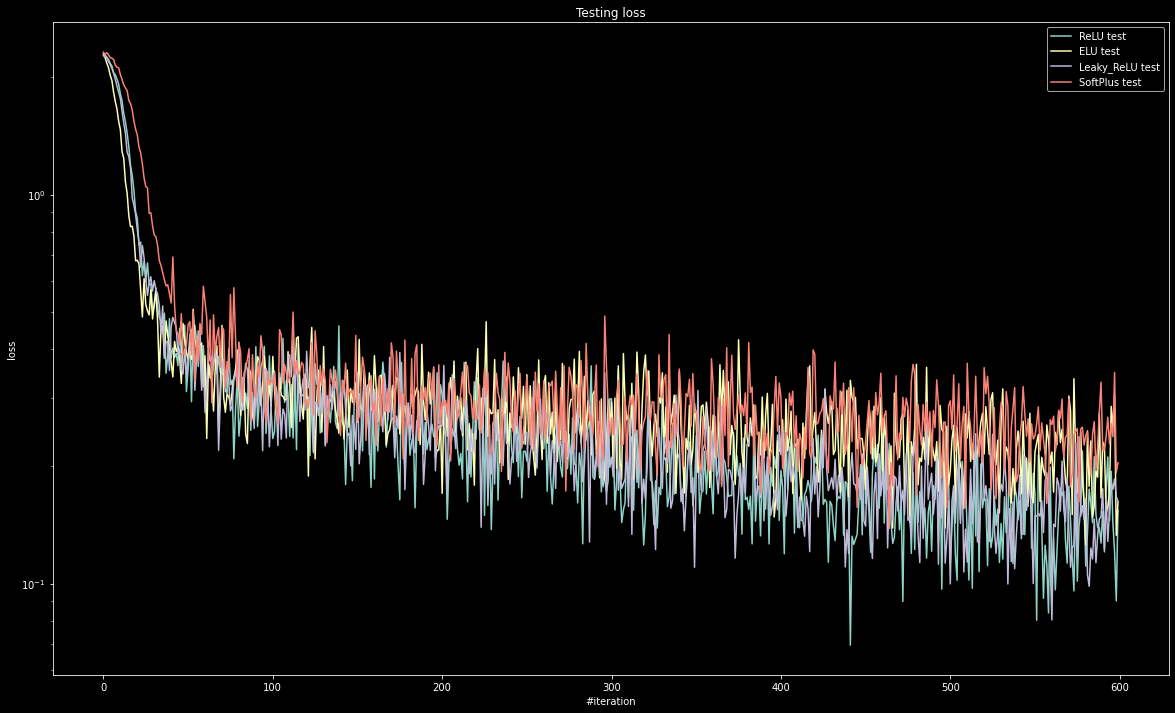

In [150]:
plt.figure(figsize=(20, 12))
plt.title("Testing loss")
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.semilogy(loss_history_ReLU_test, label='ReLU test')
plt.semilogy(loss_history_ELU_test, label='ELU test')
plt.semilogy(loss_history_LeakyReLU_test, label='Leaky_ReLU test')
plt.semilogy(loss_history_SoftPlus_test, label='SoftPlus test')
plt.legend()
plt.show()

На графиках видно, что модели с ReLU и LeakyReLU показывают меньший loss как на train, так и на test выборках

На примере сети с ReLU  посмотрим, что изменится при использовании batch normalization

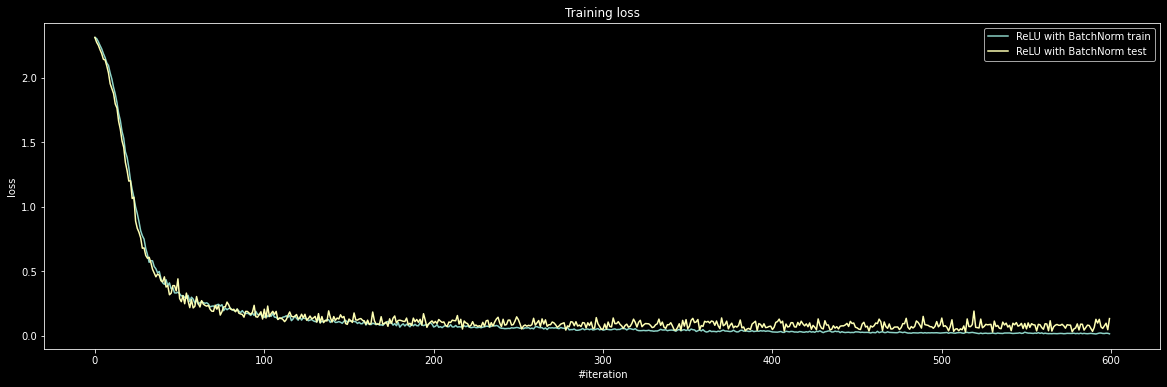

Current train loss: 0.01574420563418639
Current test loss: 0.13384109324896154


In [157]:
#ReLU with Batch Normalization
# Optimizer params
optimizer_config_BNReLU = {'learning_rate' : 5e-2, 'momentum': 0.9}
optimizer_state_BNReLU = {}

net_BNReLU = Sequential()
net_BNReLU.add(Linear(784, 256))
net_BNReLU.add(BatchNormalization(0.4))
net_BNReLU.add(ChannelwiseScaling(256))
net_BNReLU.add(ReLU())
net_BNReLU.add(Linear(256, 10))
net_BNReLU.add(BatchNormalization(0.4))
net_BNReLU.add(ChannelwiseScaling(10))
net_BNReLU.add(LogSoftMax())

criterion_BNReLU = ClassNLLCriterion()

n_epoch = 15
batch_size = 1500
batch_size_test = 250

loss_history_BNReLU = []
loss_history_BNReLU_test = []

for i in range(n_epoch):
    print(f'Epoch = {i+1}')
    for (x_batch, y_batch), (x_batch_test, y_batch_test) in zip(get_batches((X_train, y_train), batch_size), get_batches((X_test, y_test), batch_size_test)):
        net_BNReLU.zeroGradParameters()
        
        # Forward
        predictions_BNReLU = net_BNReLU.forward(x_batch)
        loss_BNReLU = criterion_BNReLU.forward(predictions_BNReLU, y_batch)
        
        # Backward
        dp_BNReLU = criterion_BNReLU.backward(predictions_BNReLU, y_batch)
        net_BNReLU.backward(x_batch, dp_BNReLU)
        
        # Update weights
        sgd_momentum(net_BNReLU.getParameters(), net_BNReLU.getGradParameters(), optimizer_config_BNReLU, optimizer_state_BNReLU)
        
        loss_history_BNReLU.append(loss_BNReLU)
      
        pred_BNReLU_test = net_BNReLU.forward(x_batch_test)
        loss_BNReLU_test = criterion_BNReLU.forward(pred_BNReLU_test, y_batch_test)
        loss_history_BNReLU_test.append(loss_BNReLU_test)
        
    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(20, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history_BNReLU, label='ReLU with BatchNorm train')
    plt.plot(loss_history_BNReLU_test, label='ReLU with BatchNorm test')
    plt.legend()
    plt.show()

    print(f'Current train loss: {loss_BNReLU}')
    print(f'Current test loss: {loss_BNReLU_test}')

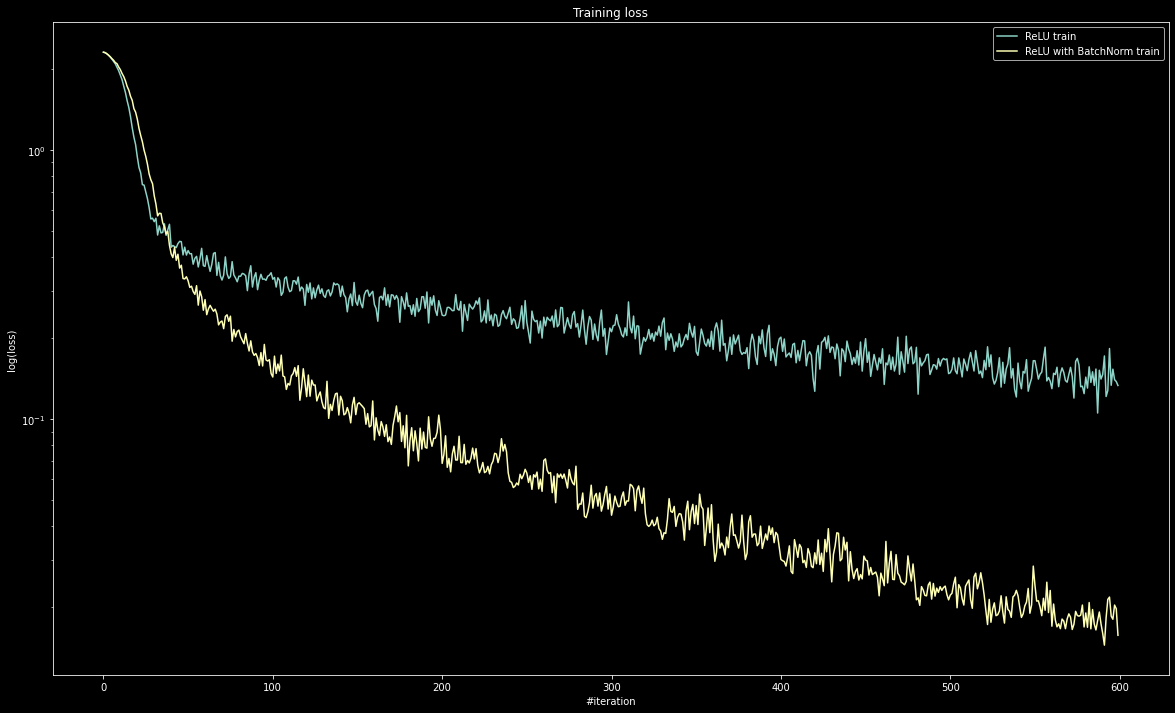

In [158]:
plt.figure(figsize=(20, 12))
plt.title("Training loss")
plt.xlabel("#iteration")
plt.ylabel("log(loss)")
plt.semilogy(loss_history_ReLU, label='ReLU train')
plt.semilogy(loss_history_BNReLU, label='ReLU with BatchNorm train')
plt.legend()
plt.show()

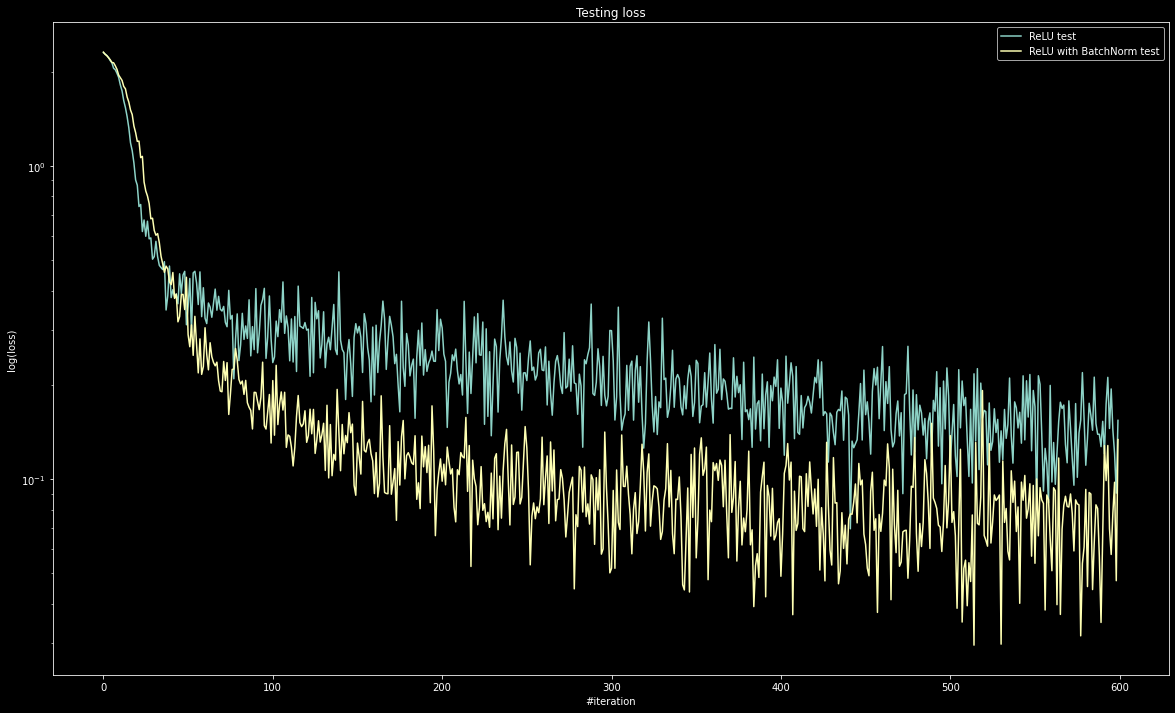

In [159]:
plt.figure(figsize=(20, 12))
plt.title("Testing loss")
plt.xlabel("#iteration")
plt.ylabel("log(loss)")
plt.semilogy(loss_history_ReLU_test, label='ReLU test')
plt.semilogy(loss_history_BNReLU_test, label='ReLU with BatchNorm test')
plt.legend()
plt.show()

На графиках в логарифмическом масштабе видно, что batch normalization уменьшил ошибку как на train, так и на test выборке

Исследуем на сети с ReLU разницу двух оптимизаторов: Adam и sgd_momentum

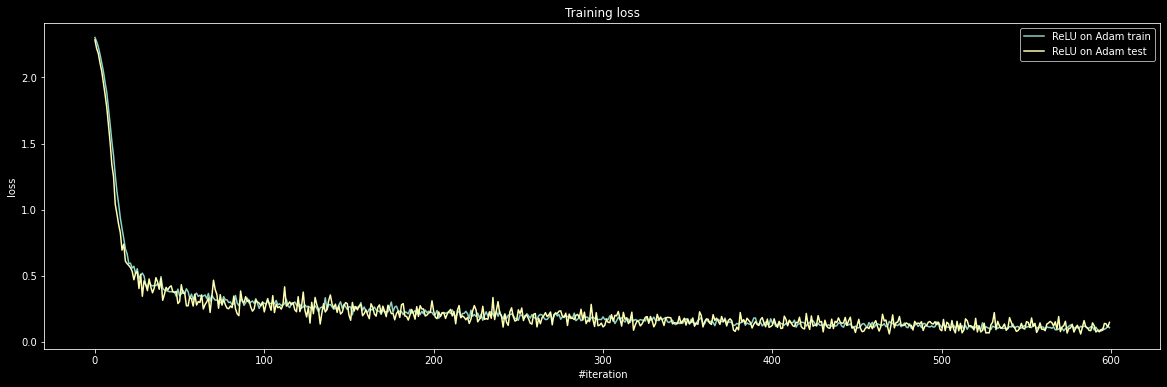

Current train loss: 0.10668539198118832
Current test loss: 0.1469540673863423


In [154]:
#ReLU on Adam
# Optimizer params
optimizer_config_AdamReLU = {'learning_rate':8e-2, 'beta1':0.9, 'beta2':0.95, 'epsilon':1e-1}
optimizer_state_AdamReLU = {}

net_AdamReLU = Sequential()
net_AdamReLU.add(Linear(784, 256))
net_AdamReLU.add(ReLU())
net_AdamReLU.add(Linear(256, 10))
net_AdamReLU.add(LogSoftMax())

criterion_AdamReLU = ClassNLLCriterion()

n_epoch = 15
batch_size = 1500
batch_size_test = 250

loss_history_AdamReLU = []
loss_history_AdamReLU_test = []

for i in range(n_epoch):
    print(f'Epoch = {i+1}')
    for (x_batch, y_batch), (x_batch_test, y_batch_test) in zip(get_batches((X_train, y_train), batch_size), get_batches((X_test, y_test), batch_size_test)):
        net_AdamReLU.zeroGradParameters()
        
        # Forward
        predictions_AdamReLU = net_AdamReLU.forward(x_batch)
        loss_AdamReLU = criterion_AdamReLU.forward(predictions_AdamReLU, y_batch)
        
        # Backward
        dp_AdamReLU = criterion_AdamReLU.backward(predictions_AdamReLU, y_batch)
        net_AdamReLU.backward(x_batch, dp_AdamReLU)
        
        # Update weights
        adam_optimizer(net_AdamReLU.getParameters(), net_AdamReLU.getGradParameters(), optimizer_config_AdamReLU, optimizer_state_AdamReLU)
        
        loss_history_AdamReLU.append(loss_AdamReLU)
      
        pred_AdamReLU_test = net_AdamReLU.forward(x_batch_test)
        loss_AdamReLU_test = criterion_AdamReLU.forward(pred_AdamReLU_test, y_batch_test)
        loss_history_AdamReLU_test.append(loss_AdamReLU_test)
        
    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(20, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history_AdamReLU, label='ReLU on Adam train')
    plt.plot(loss_history_AdamReLU_test, label='ReLU on Adam test')
    plt.legend()
    plt.show()

    print(f'Current train loss: {loss_AdamReLU}')
    print(f'Current test loss: {loss_AdamReLU_test}')

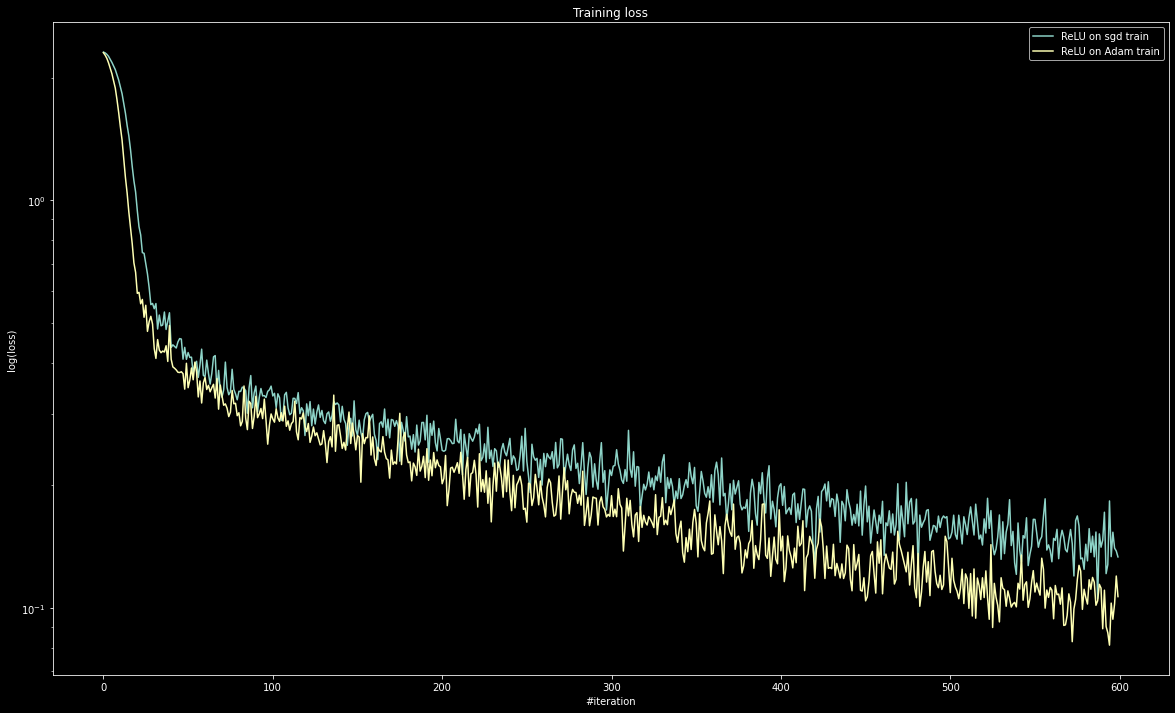

In [155]:
plt.figure(figsize=(20, 12))
plt.title("Training loss")
plt.xlabel("#iteration")
plt.ylabel("log(loss)")
plt.semilogy(loss_history_ReLU, label='ReLU on sgd train')
plt.semilogy(loss_history_AdamReLU, label='ReLU on Adam train')
plt.legend()
plt.show()

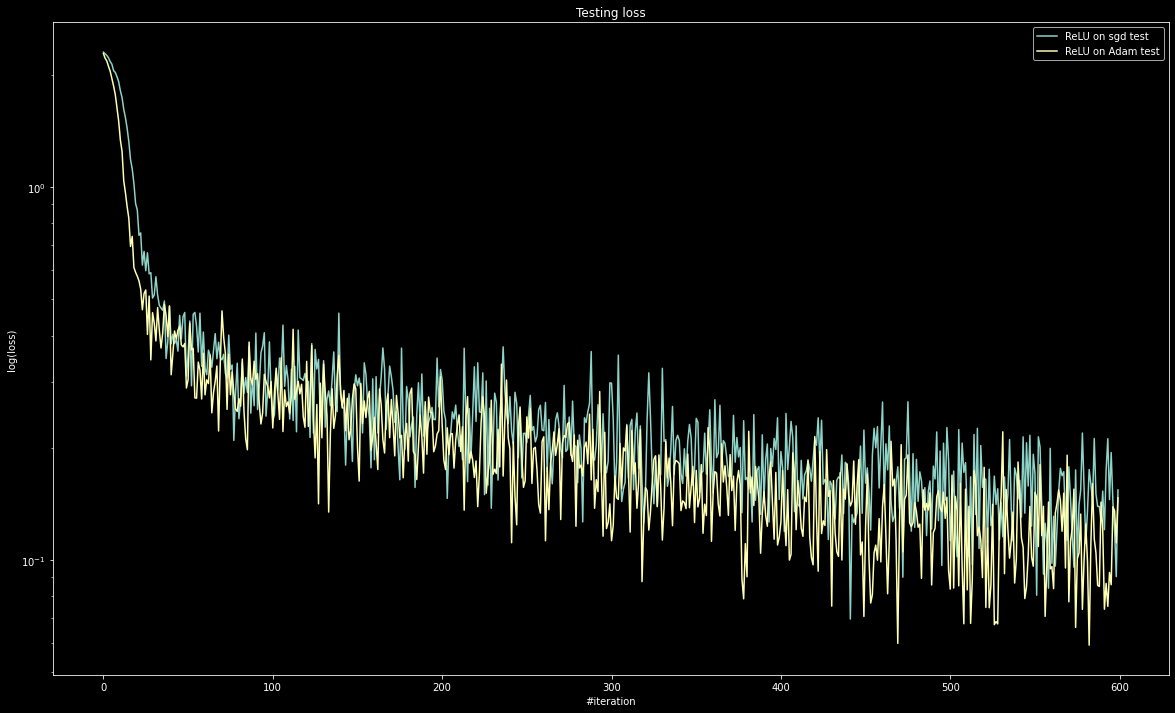

In [156]:
plt.figure(figsize=(20, 12))
plt.title("Testing loss")
plt.xlabel("#iteration")
plt.ylabel("log(loss)")
plt.semilogy(loss_history_ReLU_test, label='ReLU on sgd test')
plt.semilogy(loss_history_AdamReLU_test, label='ReLU on Adam test')
plt.legend()
plt.show()

Модели не сильно отличаются, но c Adam loss немного меньше

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?


BatchNormalization помогло с точки зрения уменьшения loss, однако время работы не уменьшилось особо

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

In [160]:
# Your code goes here. ################################################
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

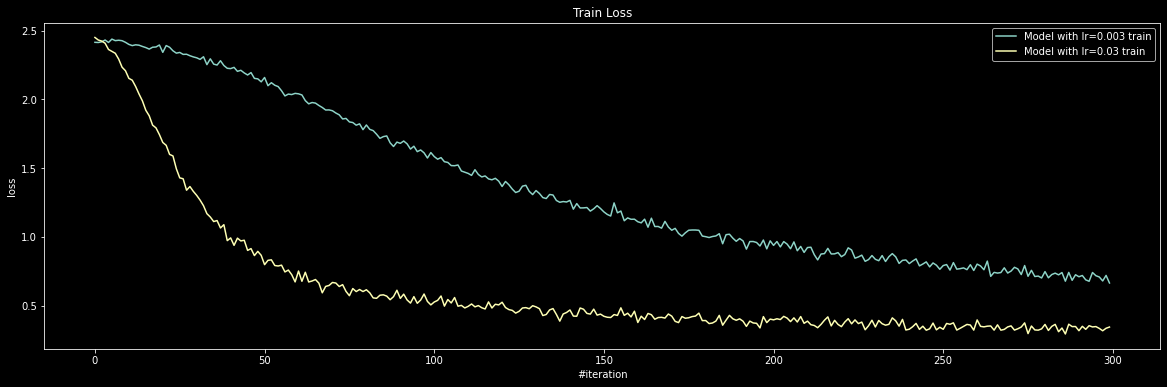

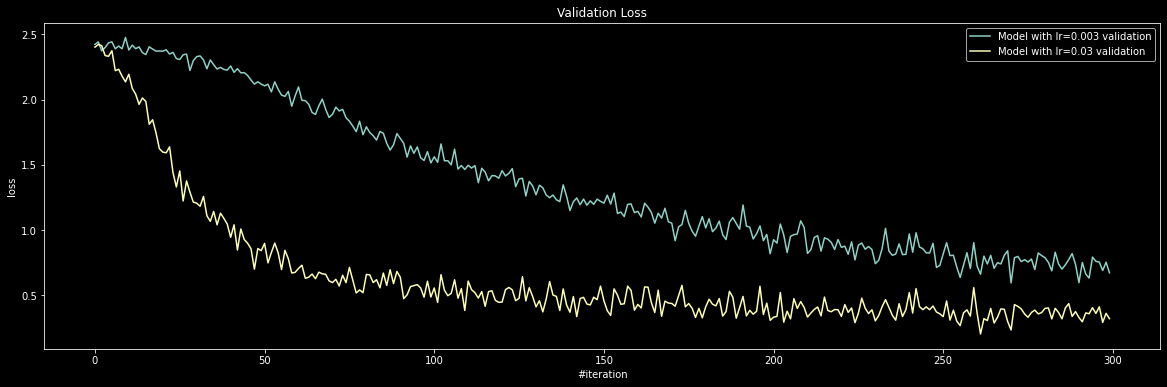

In [163]:
input_shape = X_train.shape[1]

cool_model1 = Sequential()
cool_model1.add(Linear(input_shape, 256))
cool_model1.add(ReLU())
cool_model1.add(BatchNormalization(0.9))
cool_model1.add(Dropout(0.8))
cool_model1.add(Linear(256, 512))
cool_model1.add(ReLU())
cool_model1.add(BatchNormalization(0.9))
cool_model1.add(Dropout(0.5))
cool_model1.add(Linear(512, 10))
cool_model1.add(ReLU())
cool_model1.add(LogSoftMax())

cool_model2 = Sequential()
cool_model2.add(Linear(input_shape, 256))
cool_model2.add(ReLU())
cool_model2.add(BatchNormalization(0.9))
cool_model2.add(Dropout(0.8))
cool_model2.add(Linear(256, 512))
cool_model2.add(ReLU())
cool_model2.add(BatchNormalization(0.9))
cool_model2.add(Dropout(0.5))
cool_model2.add(Linear(512, 10))
cool_model2.add(ReLU())
cool_model2.add(LogSoftMax())

optimizer_config1 = {'learning_rate': 0.003, 'beta1':0.9, 'beta2':0.999, 'epsilon':1e-1}
optimizer_state1 = {}
optimizer_config2 = {'learning_rate': 0.03, 'beta1':0.9, 'beta2':0.999, 'epsilon':1e-1}
optimizer_state2 = {}

criterion = ClassNLLCriterion()

n_epoch = 10
batch_size = 1500
batch_size_test = 250

loss_history_train_1 = []
loss_history_val_1 = []
loss_history_train_2 = []
loss_history_val_2 = []

for i in range(n_epoch):
    print(f'Epoch = {i+1}')
    for (x_batch, y_batch), (x_batch_test, y_batch_test) in zip(get_batches((X_train, y_train), batch_size), get_batches((X_val, y_val), batch_size_test)):
        cool_model1.zeroGradParameters()
        cool_model2.zeroGradParameters()

        # Forward
        predictions1 = cool_model1.forward(x_batch)
        loss1 = criterion.forward(predictions1, y_batch)

        predictions2 = cool_model2.forward(x_batch)
        loss2 = criterion.forward(predictions2, y_batch)

        # Backward
        dp1 = criterion.backward(predictions1, y_batch)
        cool_model1.backward(x_batch, dp1)

        dp2 = criterion.backward(predictions2, y_batch)
        cool_model2.backward(x_batch, dp2)

        # Update weights
        adam_optimizer(cool_model1.getParameters(), cool_model1.getGradParameters(), optimizer_config1, optimizer_state1)
        adam_optimizer(cool_model2.getParameters(), cool_model2.getGradParameters(), optimizer_config2, optimizer_state2)
        
        loss_history_train_1.append(loss1)
        loss_history_train_2.append(loss2)
      
        pred_test1 = cool_model1.forward(x_batch_test)
        loss_test1 = criterion.forward(pred_test1, y_batch_test)
        loss_history_val_1.append(loss_test1)
 
        pred_test2 = cool_model2.forward(x_batch_test)
        loss_test2 = criterion.forward(pred_test2, y_batch_test)
        loss_history_val_2.append(loss_test2)


    # Visualize
    display.clear_output(wait=True)

    plt.figure(figsize=(20, 6))      
    plt.title("Train Loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history_train_1, label='Model with lr=0.003 train')
    plt.plot(loss_history_train_2, label='Model with lr=0.03 train')
    plt.legend()
    plt.show()

    plt.figure(figsize=(20, 6))       
    plt.title("Validation Loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history_val_1, label='Model with lr=0.003 validation')
    plt.plot(loss_history_val_2, label='Model with lr=0.03 validation')
    plt.legend()
    plt.show()

Print here your accuracy on test set. It should be around 90%.

In [168]:
# Your answer goes here. ################################################
from sklearn.metrics import accuracy_score
cool_model2.evaluate()
accuracy_score(encoder.inverse_transform(y_test), encoder.inverse_transform(cool_model2.forward(X_test)))

0.9406

### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

In [169]:
# Your beautiful code here.

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


from torch.nn import functional as F

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [170]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'mnist'
mkdir(root_path)

Directory mnist is created!


In [171]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


mnist_dataset_train = torchvision.datasets.MNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
mnist_dataset_test = torchvision.datasets.MNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw


Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw


Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw


Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [172]:
train_loader = torch.utils.data.DataLoader(mnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(mnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [173]:
len(mnist_dataset_test)

10000

In [174]:
for img, label in train_loader:
    print(img.shape)
    # print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


In [175]:
class MyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256, momentum=0.9),
            nn.Dropout(0.8),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512, momentum=0.9),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),
            nn.ReLU(),
            nn.LogSoftmax()
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [176]:
torchsummary.summary(MyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 256]         200,960
              ReLU-3                  [-1, 256]               0
       BatchNorm1d-4                  [-1, 256]             512
           Dropout-5                  [-1, 256]               0
            Linear-6                  [-1, 512]         131,584
              ReLU-7                  [-1, 512]               0
       BatchNorm1d-8                  [-1, 512]           1,024
           Dropout-9                  [-1, 512]               0
           Linear-10                   [-1, 10]           5,130
             ReLU-11                   [-1, 10]               0
       LogSoftmax-12                   [-1, 10]               0
Total params: 339,210
Trainable params: 339,210
Non-trainable params: 0
-------------------------------

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [178]:
model = MyNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.03) 
loss_func = nn.CrossEntropyLoss() 

In [179]:
def train(model, device, train_loader, criterion, optimizer): 
    torch.manual_seed(5)

    model.train()

    current_train_accuracy = 0
    running_loss = 0
    pred = 0
    correct = 0
    for data, label in train_loader:
        data, label = data.to(device), label.to(device)

        optimizer.zero_grad()
        output = model(data)

        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(label.view_as(pred)).sum().item()
    
    current_loss = running_loss / len(train_loader.dataset)
    print(f'Current train loss = {current_loss}')

    current_train_accuracy = correct / len(train_loader.dataset)
    print(f'Current train accuracy = {current_train_accuracy}')

    return current_loss, current_train_accuracy


def test(model, device, test_loader, criterion):
    model.eval()

    current_test_loss = 0
    current_test_accuracy = 0 

    test_loss = 0
    correct = 0   
    running_loss = 0
    with torch.no_grad():
        for data, label in test_loader:
            data, label = data.to(device), label.to(device)
            output = model(data)

            test_loss = criterion(output, label)
            running_loss += test_loss.item()

            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(label.view_as(pred)).sum().item()

    current_test_loss = running_loss / len(test_loader.dataset) 
    print(f'Current test loss = {current_test_loss}')

    current_test_accuracy = correct / len(test_loader.dataset)
    print(f'Current test accuracy = {current_test_accuracy}')

    return current_test_loss, current_test_accuracy



Training Epoch 1


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Current train loss = 0.0041184949452678365
Current train accuracy = 0.8371166666666666
Current test loss = 0.000837944632768631
Current test accuracy = 0.9361
Training Epoch 2
Current train loss = 0.001970751064643264
Current train accuracy = 0.9225833333333333
Current test loss = 0.0008462540628854185
Current test accuracy = 0.9392
Training Epoch 3
Current train loss = 0.0011277487829948465
Current train accuracy = 0.95485
Current test loss = 0.000900814127526246
Current test accuracy = 0.9408
Training Epoch 4
Current train loss = 0.0007352278732694685
Current train accuracy = 0.9709833333333333
Current test loss = 0.0010780333726666867
Current test accuracy = 0.9357
Training Epoch 5
Current train loss = 0.0005196473388001323
Current train accuracy = 0.9784
Current test loss = 0.0011505657733418048
Current test accuracy = 0.9406
Training Epoch 6
Current train loss = 0.0004709633804081629
Current train accuracy = 0.98075
Current test loss = 0.0011892725228331983
Current test accuracy =

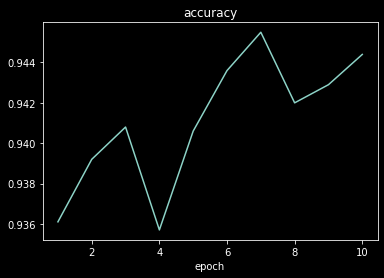

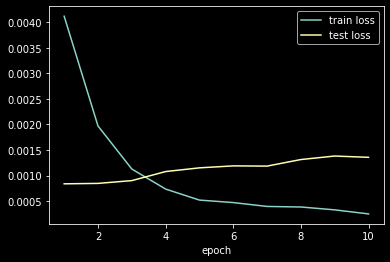

In [180]:
epochs = 10

test_loss_history = list()
train_loss_history = list()
test_ac_history = list()
train_ac_history = list()

train_loss = 0
test_loss = 0
test_ac = 0
train_ac = 0
for epoch in range(1, epochs+1):
    print(f'Training Epoch {epoch}')
    train_loss, train_ac = train(model, device, train_loader, loss_func, opt)
    test_loss, test_ac = test(model, device, test_loader, loss_func)
    
    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)
    test_ac_history.append(test_ac)
    train_ac_history.append(train_ac)

grid = np.arange(1, epochs + 1)

plt.plot(grid, test_ac_history, label='test accuracy')
# plt.plot(grid, train_ac_history, label='train accuracy')
plt.xlabel("epoch")
plt.title("accuracy")
plt.show()

plt.plot(grid, train_loss_history, label='train loss')
plt.plot(grid, test_loss_history, label='test loss')
plt.xlabel("epoch")
plt.legend()
plt.show()



In [181]:
test_ac

0.9444